# 15.083 Writeup 

## Introduction and overview of methods

### Motivation
Spacecraft design tends to be a laborious and manual procedure, where engineers iterate on evaluating the perfomance while having a consistent design, i.e satisfying so-called budgets (a.k.a. constraints).

One interesting part of the problem is that although one could start from scratch to custom design all parts of a spacecraft(e.g. a satellite), companies generally try to save on development efforts by picking components from a database - either internal to the company, or from larger market availability. 

Building a spacecraft based on commercially-off-the-shelf components is especially attractive within the new paradigm of CubeSats: a standard for cubesat component sizing and interfaces - turning the spacecraft problem into picking the right "LEGO" bricks, and reducing the engineering part to simple assembly and integration(saving a lot on development time). 

Yet it still leaves the frustration of picking the right component to the engineer; normally the procedure will be quite manual and the engineer will iterate through both picking components, and making sure all constraints are satisfied. It can often be very much a whack-a-mole process, leading either to the engineers frustration, or indifference to looking for better solutions once the design converges on something that works - given the feel that any design changes will just be the same as starting from scratch and having to suffer through yet more frustrations.


### The MINLP optimization approach
Here we present the optimization approach; the components selection process translate easily into a Mixed Integer formulation. The challenge is that most of the physical sizing constraints are highly non-linear, and oftentimes non-linear in more than one variable. 

With further careful consideration, one can notice though, that many of the relationships are power laws: products of powers, or sum of products of powers. This is very promising, as this becomes a linear problem in log space, as long as any factors in front of the powers are positive. 

Unfortunately there are still sometimes models that cannot be captured by this reformulation. These are oftentimes univariate expressions, and therefore the approach we take is to use PiecewiseLinear in JuMP to model them.

Finally, we might sometimes encounter disjoint constraints, where the choice is between two component with different physical models. This can also be introduced with a simple modelling technique.

### The optimization problem

It is fairly accepted that mass can be used as a proxy for cost when it comes to spacecraft. We also choose it over cost, as many times the cost models or cost(in terms of \$) information is proprietary. Therefore we will use mass as the objective function in the optimization problem.

Here we will focus on the optimization of an Earth-Observation satellite with a minimum resolution required, while minimizing the satellite's mass. We will also introduce a minimum lifetime constraint to ensure the missions lasts for a minimum amount of time.

**Component selection MIP formulation**

For the toy problem(which is much less a toy problem now, and getting closer to covering a lot of the real constraints) we will have a catalog for four type of components:

1. Antenna (antenna diameter, maximum power, and mass) 
1. Battery (energy storage, mass)
1. Payload (optical diameter, mass)
1. Solar panel (solar panel efficiency, surface mass density)

Obviously there are a lot of other satellites components that we can find in catalogs; this can easily be extended for the propulsion and magnetorquer models that are currently being optimized over a continuous domain. We keep it restricted for now just out of time constraints(and not because the framework is limitted).

For the MIP formulation, we will create binary variables for each component in the catalog, and set a constraint that only one can be picked for each type of catalog.

Next we introduce all the models in their natural form. We have included constraints from 7 different but highly interconnected domains:

1. Orbits
1. Power
1. Payload performance 
1. Communication
1. Satellite lifetime
1. Momentum management
1. Mass models

## Models useds
### 1. Orbits
Given a certain altitude h, the semi-major axis is defined as $a = R_e + h$, where $R_e = 6.378km$ is the radius of the Earth. Then the period T is defined as:

$T = 2\pi\sqrt{\frac{a^3}{\mu}}$

$\mu = 3.98\cdot10^{14}m^3/s^2$

The ground station communication time $g$ is given by the relationship:

$g = \frac{1}{\pi}arccos\left(\frac{R_e}{R_e+h}\right)$

This can be derived from equation (5-24) in SMAD(see figure 5-13 for geometry):

$\lambda_0 = arccos\left(\frac{R_e}{R_e+h}\right) $ 

This is half of the angle that is actually visible from the ground station. If we normalize by $2\pi$ we get the fraction of the circle, since we assumed circular orbit:

$g = \frac{1}{2\pi}2 arccos\left(\frac{R_e}{R_e+h}\right)$

The daylight fraction time is given by a similar expression:

$d = \frac{\pi+2\lambda}{2\pi} = g + 0.5$

### 2. Power

Given a solar panel of efficiency $\eta_s$, and area $A$, the solar panel charging power will be:

$ P_t = d A \eta_s Q $

Where $Q=1367W/m^2$ is the solar constant, and $d$ is still the daylight fraction as already defined.

Battery

$ E_b = \frac{1}{d} P_t \cdot T $

### 3. Payload
The payload is assumed to be an Earth-imaging camera, and we assume that its resolution, which we have been given a requirement on, is diffraction limitted. This gives the following relationship:

$ X_r = h \frac{\lambda}{D} $

Where $h$ is the satellite's altitude, $\lambda$ the imaging wavelength and $D$ the aperture of the camera.  

### 4. Communications

We will assume that every orbit we need to downlink all the data that has been gathered by the payload. Assuming the payload is always recording a strip underneath it with length $N\cdot X_R$ where $X_R$ is the resolution of the payload. The total data $D$ recorded then is just the amount of pixels needed to represent a full sweep of the earth, i.e. $\frac{2\pi R_e}{X_R} $ time the width $N$, times the amount of bits per pixel $B$ :

$D = \frac{2\pi R_e}{X_R}\cdot B\cdot N$

All this data needs to be downloaded during a ground station pass, so the bit rate $b$ then becomes:

$b = \frac{D}{T} $

#### Link budget
This equation describes the signal to noise ratio of a communication link. Normally the SNR, here through the measure energy per bit over noise energy, needs to be above a given threshold in order to be decoded by the ground station.

$ E_{b}/N_{o} = \frac{P_{Tx} \cdot G_{Rx}}{L_{other} \cdot k \cdot T_{sys} \cdot  b}\eta \left( \frac{D_{Tx}}{4r} \right)^2$

Since $b$ has been previously defined we can easily replace it's expression into this equation. This has been done for the optimization formulation.

Where $r = \sqrt{h^2 + 2R_eh}$ is the distance from the satellite to the furthest visible point on the surface of the Earth.

### 5. Lifetime of the satellite

Total lifetime $L_t$ is the sum of two parts, the natural decay time due to drag $L_n$, and the time we can keep the satellite from decaying by countering the drag with propulsion, $L_p$.

$ L_n = \frac{H \cdot m_t}{2\pi \cdot C_D \cdot A \cdot \rho \cdot a^2} $ Eq. (6-28) from SMAD 

Where $H(h)$ and $\rho(h)$ are given by tables at the end of SMAD, which have been digitized and rendrered here:

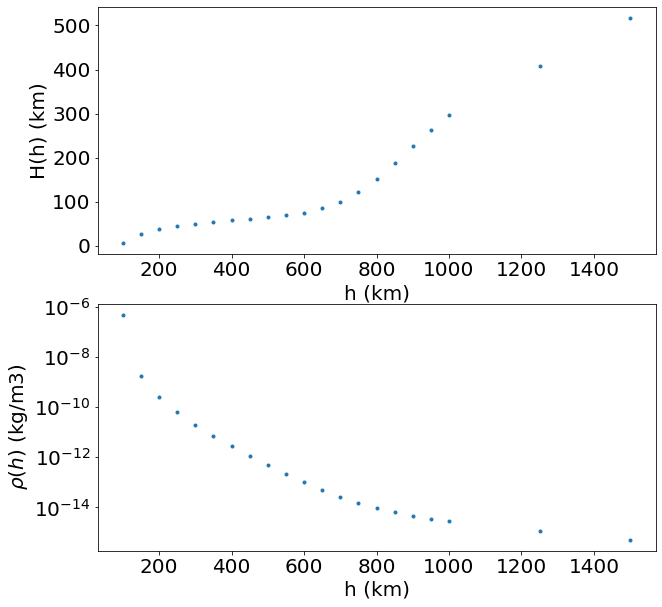

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
dragtable = pd.read_excel("SMAD_tables.xlsx", sheet_name="Drag")
H = dragtable["Scale Height"][2:].values
h = dragtable["Altitude [m]"].values[2:].astype(float)
rho = dragtable["Unnamed: 3"].values[2:].astype(float)
f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.plot(h, H, '.')
ax1.set_xlabel("h (km)")
ax1.set_ylabel("H(h) (km)")
ax2.semilogy(h, rho, '.')
ax2.set_xlabel("h (km)")
ax2.set_ylabel(r'$\rho(h)$ (kg/m3)')
plt.savefig('NLRMSISE00.eps')
plt.show()

I believe that the atmospheric models are based on the NRLMSISE-00 standard by NOAA.

For the propulsion lifetime, it is the total momentum available from propulsion, $l=m_P \cdot I_{sp} \cdot G$ divided by the drag force:

$F_D = 0.5 \rho \cdot C_D \cdot A \cdot v^2 = 0.5 \rho \cdot C_D \cdot A \cdot \frac{\mu}{a}$


$L_p = \frac{l}{F_D} = \frac{m_P \cdot I_{sp}\cdot G \cdot a}{0.5 C_D \cdot A_D \cdot \rho \cdot \mu} $ 

Turns out we actually need to add a constant to make $L_p$ realistic:

$L_p = \kappa \frac{m_P \cdot I_{sp}\cdot G \cdot a}{0.5 C_D \cdot A_D \cdot \rho \cdot \mu} $ where $\kappa$ is a constant

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


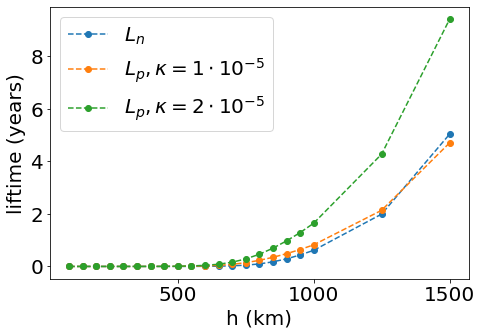

In [31]:
m = 7.240
CD = 2.2
A = 0.05261451671609104
R = 6378e3
bc1 = m/(CD*A)
ai = R+h*1000
year = 3600*24*365
mu = 3.98e14
Isp = 536
g = 9.81
ar = 2*np.pi*rho*ai**2/bc1
Ln = H*1e3*m/(2*np.pi*rho*ai**2*CD*A)/(3600*24*365) 
Lp = lambda mp: mp*Isp*g*ai/(0.5*CD*A*rho*mu)/year
ub = 800
#plt.rc('text', usetex=True)
plt.figure(figsize=(7.5,5))
plt.plot(h, Ln, '--o',
         h, 1e-5*Lp(4.3), '--o', 
         h, 2e-5*Lp(4.3), '--o')
plt.legend([r"$L_n$", "$L_p, \kappa=1\cdot10^{-5}$", "$L_p, \kappa=2\cdot10^{-5}$"])
plt.xlabel("h (km)")
plt.ylabel("liftime (years)")
plt.savefig('lifetime_P.eps')
plt.show()

The constraint is to satisfy a minimum lifetime $L_{min}$:

$L_n + L_p \leq L_{min}$ 

### 6. Momentum budget and disjoin constraints

One of the constraints spacecraft have to manage is accumulated torque due to disturbance forces acting on the spacecraft. Although there are several (solar radiation pressue, aerodynamic...) here we focus on one specific type: gravity gradient. The expression for gravity gradient is given in table 11-9A in SMAD:

$ T_g = \frac{3\mu}{a^3}c$

Where $c = |I_z-I_y|sin(2\theta)$. We choose to just set this as a constant instead of going deeper into the modelling of where $c$ comes from.

The gravity gradient can build up over time, and we investigate two ways to manage it:

1. Magnetorquers: they create a dipole moment in the spacrcraft that generates a torque on the satellite in the presence of Earth's magnetic field
2. Propulsions: small burns with attitude reaction thrusters; this requires propellant mass

Both can be tied town to the mass of their system, and the optimizer should choose the lightest one. Below are the models used:

For the thrusters, the amount of momentum that the system will have to dissipate is given by $h_p$(the letter h is also often associated with momentum, not to be confused with satellite altitude). This is modelled through the equations given in Table 11-13:

$h_p = T \cdot T_g \frac{1}/{4}\frac{sqrt(2)}{2}\cdot 3 \cdot 365\cdot L_{min} $

For the magnetorquers, we have applied a model that is not correct from the literature, but that makes the choice between thrusters and magnetorquer interesting. The assumption is that the magnetorquer can counter the torque(through the dipole moment it creates); so:

$T_m = T_g$ 

Both key metrics from the systems: $h_p$ and $T_g$ will then be used in the mass models.


### 7. Mass models

Mass models for any system that's not in the component catalog uses a simple linear relationship that was tuned to generate meaningful masses, i.e.:

$ m_i = \rho_i \cdot f_i $ 

Where $m_i$ is the mass of certain component not in the catalog(except for the solar panel), $\rho_i$ is the density, and $f_i$ is the performance. $f_i$ for momentum management is both $h_p$ and $T_g$. $f_i$ for the surface is the area, and this time the constant $\rho_i$ is given by the component selection in the catalog. 

Finally, we have included the structural mass as a percentage of the total system(20% in this case).

## Some notes on reformulation
Most constraints in the modelling are equality constraints; they can however be turned into inequality constraints if one know on which side of the equality the pressure lies. This is what effectively allows sums of powers to be put in logspace through inequalities. Sometimes, however there is no such pressure, and it was realized later that the expression

$a = h + R$, which was reformulated as $h + R \leq a$:

1. $e^{R - a} \leq exp_{Ra}$
1. $e^{h - a} \leq exp_{ha}$
1. $exp_{Ra} + exp_{ha} \leq 1$

Where $R$, $h$, and $a$ are in logspace. This assumes a certain pressure on $a$ which turned out not to be true, due to it's relationship with the orbit period $T$ and the comms link budget, where $T$ ideally wants to be larger to satisfy the link budget constraint. Therefore, this constraint had to be encoded through the Piecewiselinear formulation.

## Catalog components
A mini-catalog was generated with two options for each component except the battery which has 5. This leads to 2x2x2x5 = 30 possible combinations; which is manageable; but not scalable when including perhaps 100s of components. The components where found from an online database of spacecraft components [satsearch.co](https://satsearch.co), and some of the values were tweaked to play around with the problem. 

For simplicity of the writeup consult data.jl to see the catlog components.

## Results

Since this is a python notebook (the project was originally started in python, when using GpKit, so some legacy code like extracting the excel tables, was kept in python), we will just display some of the results from the code, and show that the results are non trivial.

As we change the resultion requirement and lifetime we get very different designs. Here we show the results from two runs:

1. 15m resolution 5 years
2. 5m resolution 3 years

### 1. 15m resolution, 5 years
![results1.PNG](https://www.dropbox.com/s/1260hniqdfjy3bh/results1.PNG?raw=1)

Payload 1 is chosen(lower aperture than payload 2, but much lighter), and the orbit is brough to 1200km. This is the altitude that satisifies the resolution constraint given the camera aperture. Choosing this altitude comes at some significant propellant mass penalty, but seems to outweight the choice of having a heavier payload with better performance. 

The optimal mass comes to ~5.24kg.

### 2. 10m resolution, 3 years
![results2.PNG](https://www.dropbox.com/s/umcno6gn2a0tbkq/results2.PNG?raw=1)

This time Payload 2 is chosen(larger aperture than payload 1, but much heavier), to meet the higher perfomance metrics required by the resolution. This also allows the orbit to be higher (1500km), giving us a longer lifetime and at less propellant cost.

The optimal mass comes to ~4.40kg, which is lighter than the first option.

## Conclusion
It took less than a minute (53s from executing the command to results), of which 21s where spent by the backend solver(there is a significant overhead to compile the problem, unfortunately). 

This gives us the opportunity to quickly compare two different options in a couple of minutes, versus the several weeks it might take to do it manually. 

### Limitations and future considerations

* The solver seems to sometime run into errors for no known reasons. 
* Further investigation should be given to how the solving time increases with the amount of catalog components
* Make the magnetorquer and propulsion system integer variables(choices) from a catalog.